1. LayoutXLM complete
2. LayoutXLM zero positions [0, 0, 0, 0]
2. LayoutXLM zero image
2. LayoutXLM zero positions + zero image
3. BERT

In [1]:
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np

folders = [r'C:\Users\Habram\Documents\thesis-masters\LayouXLM\Custom',
           r'C:\Users\Habram\Documents\thesis-masters\LayouXLM\Custom_zero-positions',
           r'C:\Users\Habram\Documents\thesis-masters\LayouXLM\Custom_no-image',
           r'C:\Users\Habram\Documents\thesis-masters\LayouXLM\Custom_text-only',
           r'C:\Users\Habram\Documents\thesis-masters\BERT']

models = ['LayoutXLM complete',
          'LayoutXLM zero layout',
          'LayoutXLM zero iamge',
          'LayoutXLM zero layout + image',
          'BERT']

variants = ['real', 'fake', 'hybrid']

label_list = ['other',
              'r_name', 'r_street', 'r_housenumber', 'r_zip', 'r_city', 'r_country',
              's_name', 's_street', 's_housenumber', 's_zip', 's_city', 's_country', 's_bank', 's_iban',
              'i_number','i_date', 'i_amount']

id2label = {0: 'O',
            1: 'B-R_NAME',
            2: 'I-R_NAME',
            3: 'B-R_STREET',
            4: 'I-R_STREET',
            5: 'B-R_HOUSENUMBER',
            6: 'I-R_HOUSENUMBER',
            7: 'B-R_ZIP',
            8: 'I-R_ZIP',
            9: 'B-R_CITY',
            10: 'I-R_CITY',
            11: 'B-R_COUNTRY',
            12: 'I-R_COUNTRY',
            13: 'B-S_NAME',
            14: 'I-S_NAME',
            15: 'B-S_STREET',
            16: 'I-S_STREET',
            17: 'B-S_HOUSENUMBER',
            18: 'I-S_HOUSENUMBER',
            19: 'B-S_ZIP',
            20: 'I-S_ZIP',
            21: 'B-S_CITY',
            22: 'I-S_CITY',
            23: 'B-S_COUNTRY',
            24: 'I-S_COUNTRY',
            25: 'B-S_BANK',
            26: 'I-S_BANK',
            27: 'B-S_IBAN',
            28: 'I-S_IBAN',
            29: 'B-I_NUMBER',
            30: 'I-I_NUMBER',
            31: 'B-I_DATE',
            32: 'I-I_DATE',
            33: 'B-I_AMOUNT',
            34: 'I-I_AMOUNT'
        }

In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(768, 35)

    def forward(self, x):
        x = self.fc(x)
        return x
    
softmax = nn.Softmax(dim=1)

In [3]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class IstvoicesDataset(Dataset):
    def __init__(self, data):
        self.labels = data['labels']
        self.embeddings =  data['embeddings']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        emb = self.embeddings[idx]
        lab = self.labels[idx]

        return emb, lab

In [4]:
def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label.lower()

def get_all_predictions(classifier, test_dataloader, testing_data):
    all_labels = []
    all_predictions = []
    
    # iterate over the whole test set
    for test_idx in range(len(testing_data['embeddings'])):
        test_features, test_labels = next(iter(test_dataloader))
        predictions = classifier(test_features)
        predictions = softmax(predictions[0])
        predictions = torch.argmax(predictions, dim=1)
        predictions = predictions.numpy()
        test_labels = test_labels[0].numpy()

        # Get the actual labels (str)
        true_predictions = [id2label[pred] for pred, label in zip(predictions, test_labels)]
        true_labels      = [id2label[label] for pred, label in zip(predictions, test_labels)]

        all_labels.append(list(map(iob_to_label, true_labels)))
        all_predictions.append(list(map(iob_to_label, true_predictions)))

    return all_labels, all_predictions

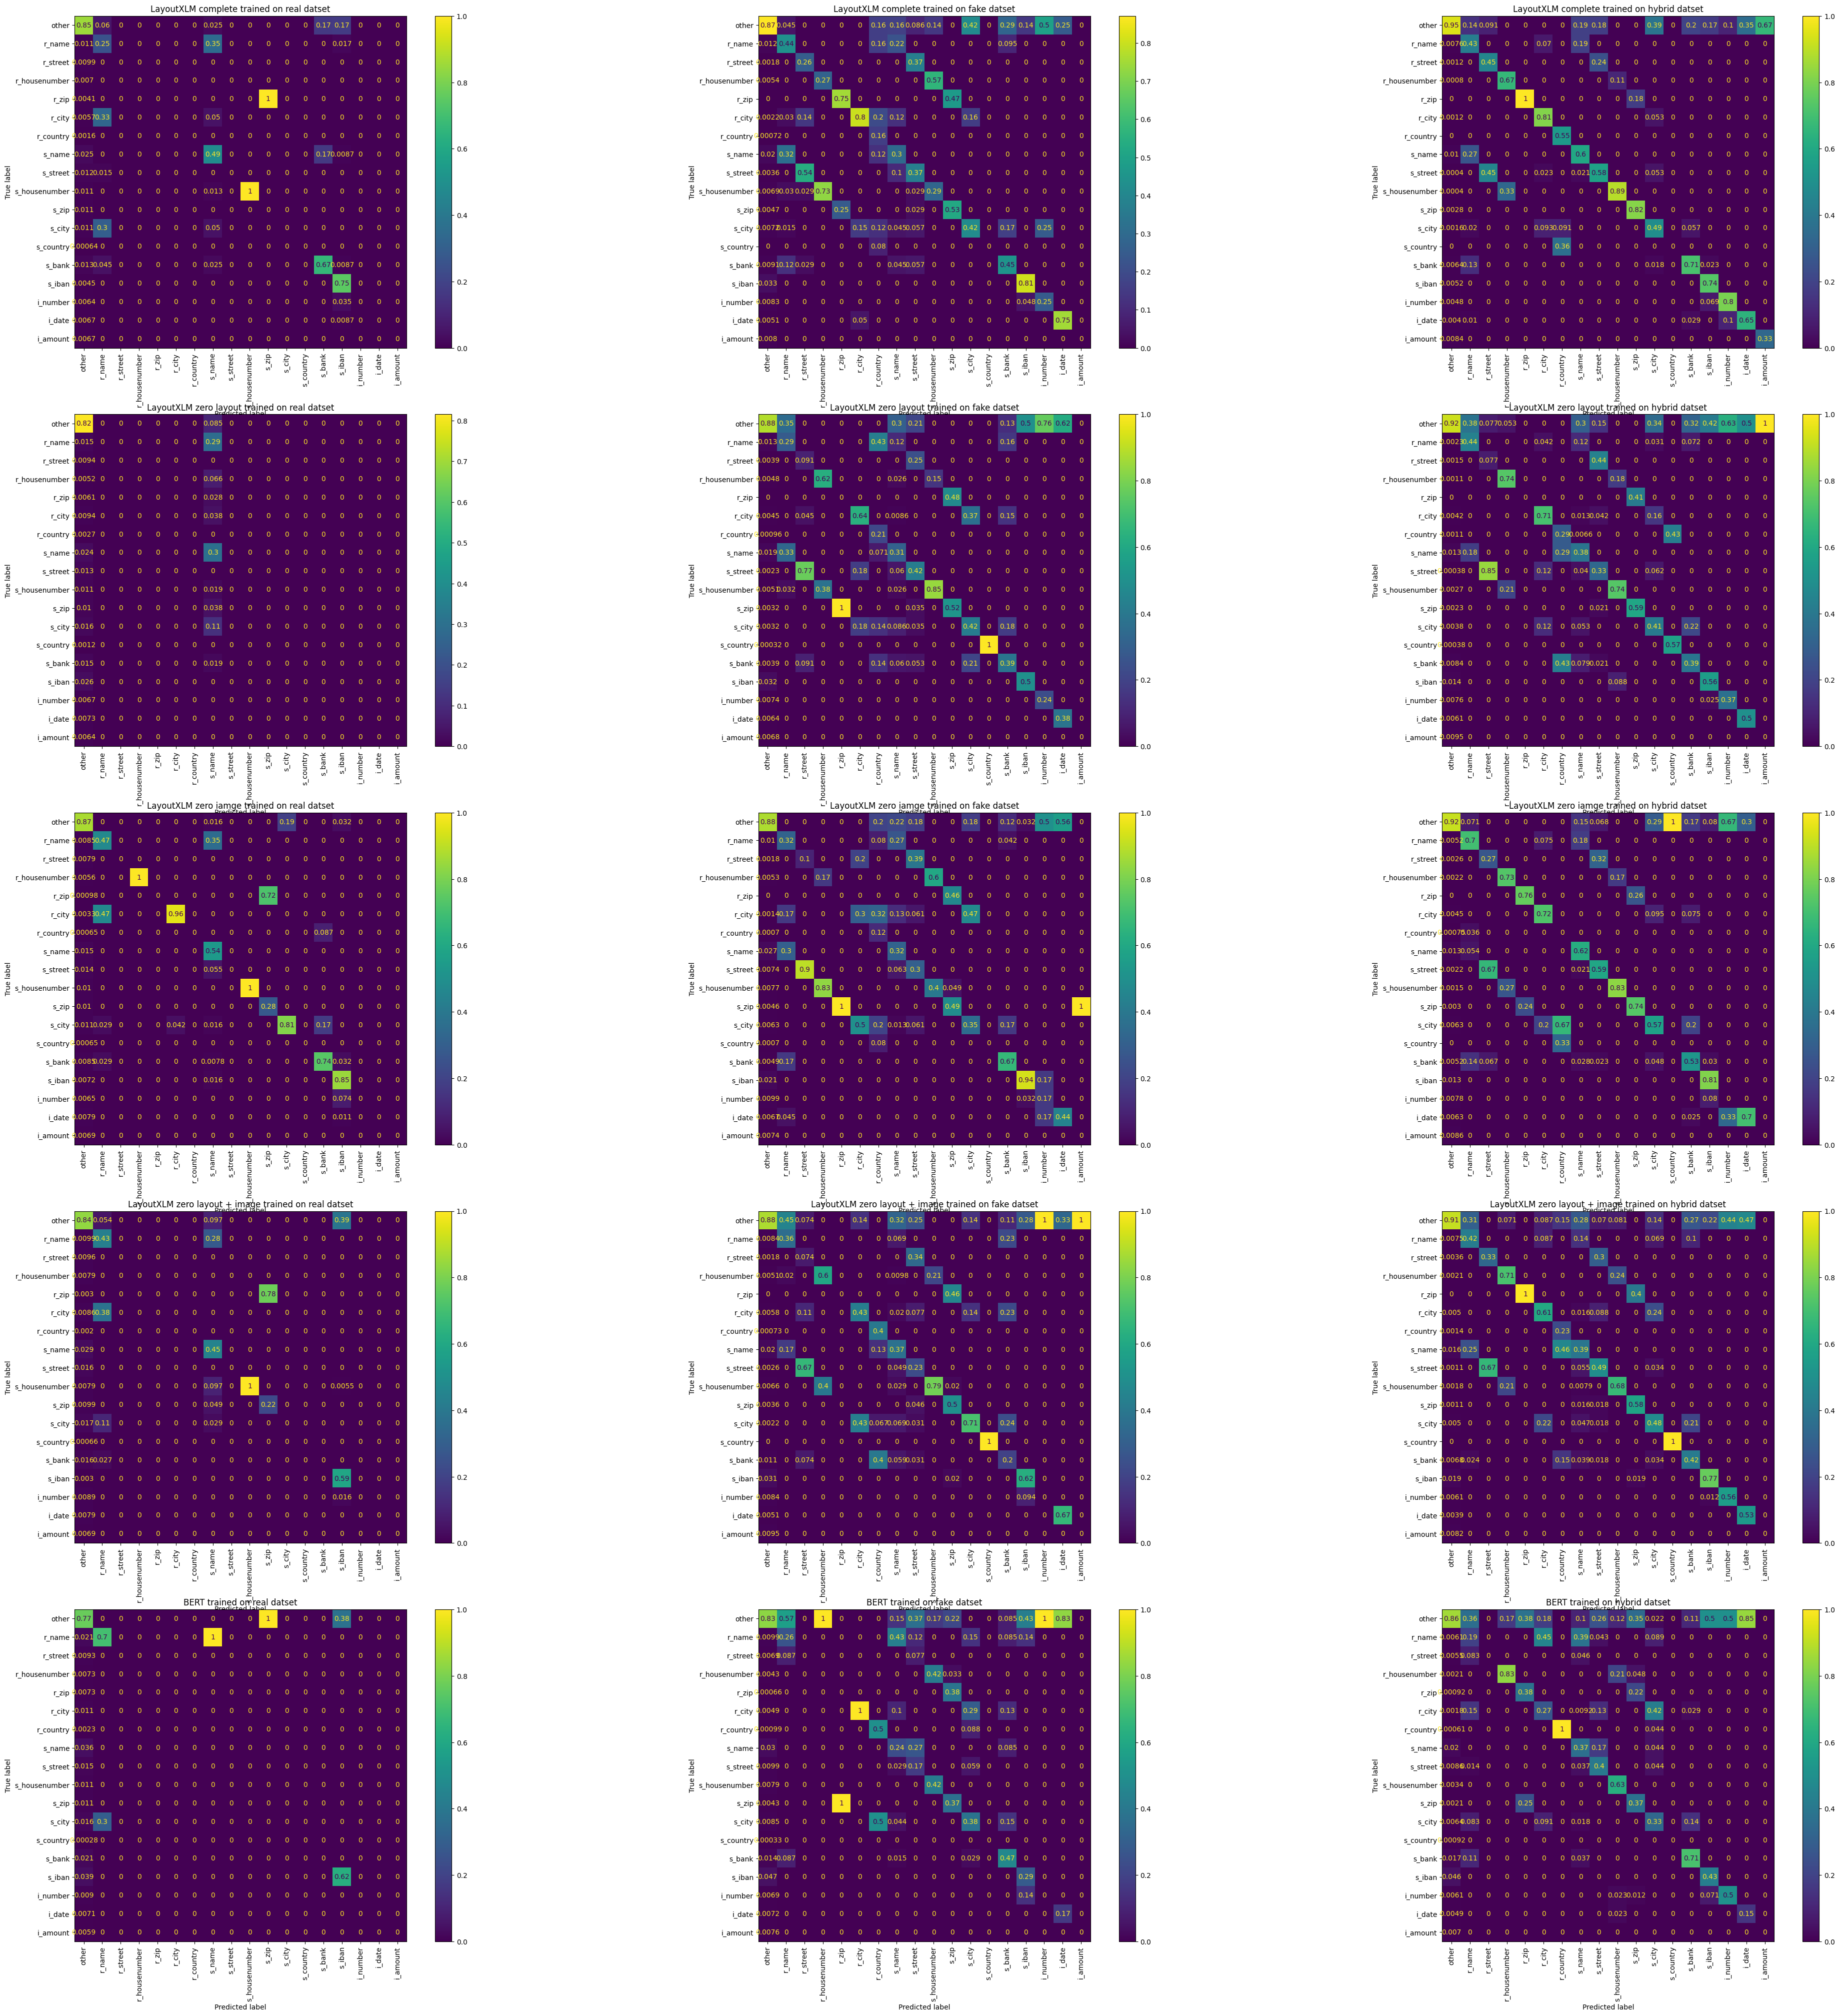

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import sklearn.metrics as sk

fig, axs = plt.subplots(5,3)
fig.set_figheight(50)
fig.set_figwidth(50)

f1_micro = []
f1_macro = []
f1_weighted = []

for x, (model, folder) in enumerate(zip(models, folders)):
    for y, variant in enumerate(variants):
        classifier = Net()
        classifier.load_state_dict(torch.load(rf'{folder}/{variant}2real_classifier.pt'))
        testing_data = np.load(rf'{folder}/{variant}2real_test.npy', allow_pickle=True).item()

        dataset_test_torch = IstvoicesDataset(testing_data)
        test_dataloader = DataLoader(dataset_test_torch, batch_size=1, shuffle=True)

        all_labels, all_predictions = get_all_predictions(classifier, test_dataloader, testing_data)

        all_labels = [item.lower() for sublist in all_labels for item in sublist]
        all_predictions = [item.lower() for sublist in all_predictions for item in sublist]

        f1_micro.append(sk.f1_score(all_labels, all_predictions, average='micro'))
        f1_macro.append(sk.f1_score(all_labels, all_predictions, average='macro'))
        f1_weighted.append(sk.f1_score(all_labels, all_predictions, average='weighted'))

        cm = confusion_matrix(y_true=all_labels, y_pred=all_predictions, labels=label_list, normalize='pred')
        cm_display = ConfusionMatrixDisplay(cm, display_labels=label_list)
        cm_display.plot(ax=axs[x][y], xticks_rotation='vertical')
        axs[x][y].set_title(f'{model} trained on {variant} datset')
plt.show()

In [10]:
print(f1_micro)
print(f1_macro)
print(f1_weighted)

[0.8265067290813342, 0.8134469696969697, 0.8834982444940951, 0.7992937021777516, 0.8157748049052397, 0.8196672608437314, 0.8519929660023446, 0.8169711985134717, 0.8711151736745887, 0.8031426030240143, 0.7976044226044227, 0.8409291384886798, 0.7690148751052484, 0.7761722205838986, 0.7964087668339055]
[0.14079847206779494, 0.2984094635908387, 0.5920190329486704, 0.0661381622591988, 0.3208036912174721, 0.4368707092595945, 0.27265221562680003, 0.24067754758756654, 0.46804255632492503, 0.14069201625348668, 0.3387175320443834, 0.47347221834638287, 0.06037146515491202, 0.191292746904112, 0.28201217693195096]
[0.7703320417508888, 0.7810011880649916, 0.8787246814892046, 0.7204992662478518, 0.7887006540128958, 0.816058031914401, 0.811467547784563, 0.7840440278393298, 0.8565763886975375, 0.7454451863321437, 0.7728200297575997, 0.8286653041873587, 0.6733441690671698, 0.7244994439422218, 0.7630644195867322]


### Dataset analysis

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import collections

variants = ['real', 'fake']
splits = ['train', 'test']

fig, axs = plt.subplots(2,2)
fig.set_figheight(20)
fig.set_figwidth(20)

for x, variant in enumerate(variants):
    dataset = load_dataset(rf'C:\Users\Habram\Documents\Datasets_final\{variant}2real\{variant}2real.py',
                 cache_dir=rf'C:\Users\Habram\Documents\Datasets_final\{variant}2real')
    
    for y, split in enumerate(splits):
        classes_list = []
        for example in dataset[split]:
            classes_list.extend(example['ner_tags'])

            length = dataset[split].num_rows

            # Count occurrences of each number
            number_counts = collections.Counter(classes_list)

            # Extract unique numbers and their counts
            unique_numbers = list(number_counts.keys())
            count_of_instances = list(number_counts.values())

            O_index = unique_numbers.index(0)
            unique_numbers.pop(O_index)
            count_of_instances.pop(O_index)

            # Create a bar plot
            axs[x][y].bar([id2label[num] for num in unique_numbers], [number / length for number in count_of_instances])
            axs[x][y].set_xlabel('Class names')
            axs[x][y].set_ylabel('Count of Instances')
            axs[x][y].set_title(f'{variant} dataset, {split} split')
            #axs[x][y].set_xticks_rotation='vertical'
            axs[x][y].set_xticklabels([id2label[num] for num in unique_numbers], rotation=90)
plt.show()

### Visualize ground truth vs. prediction

In [ ]:
draw = ImageDraw.Draw(invoice)
font = ImageFont.load_default()
width, height = invoice.size

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

label2color = {
        'R_NAME':           'lightcoral',
        'R_STREET':         'brown',
        'R_HOUSENUMBER':    'red', 
        'R_ZIP':            'Salmon',
        'R_CITY':           'chocolate',
        'R_COUNTRY':        'Sandybrown',
        'S_NAME':           'olive',      
        'S_STREET':         'yellowgreen',
        'S_HOUSENUMBER':    'lawngreen',
        'S_ZIP':            'palegreen',
        'S_CITY':           'forestgreen',
        'S_COUNTRY':        'limegreen',
        'S_BANK':           'darkgreen',
        'S_IBAN':           'teal',
        'I_NUMBER':         'aqua',
        'I_DATE':           'deepskyblue',
        'I_AMOUNT':         'blue',
        'OTHER':            'magenta'
    }

In [ ]:
from PIL import ImageDraw, ImageFont
import matplotlib.patches as patches

# Pick an invoice to investigate
variant = 'fake'

dataset = load_dataset(rf'C:\Users\Habram\Documents\Datasets_final\{variant}2real\{variant}2real.py',
             cache_dir=rf'C:\Users\Habram\Documents\Datasets_final\{variant}2real')

example = dataset['test'][0]
invoice = example['image']

fig, axs = plt.subplots(1, 2)
fig.set_figheight(20)
fig.set_figwidth(20)

for label, box in zip(example['ner_tags'], example['bboxes']):
    box_normalized = unnormalize_box(box, width, height)
    # Draw the label bounding box and name on the invoice
    if label == 0:
        label = 'OTHER'
    else:
        label = id2label[label][2:]
    top_x = box_normalized[0]
    top_y = box_normalized[1]
    box_width = box_normalized[2] - box_normalized[0]
    box_height= box_normalized[3] - box_normalized[1]
    rect1 = patches.Rectangle((top_x, top_y), box_width, box_height, linewidth=1, edgecolor=label2color[label], facecolor='none')
    axs[0].add_patch(rect1)
    axs[0].text(top_x+30, top_y-10, label, fontsize=5, color=label2color[label])
    #draw.rectangle(axs[0], box_normalized, outline=label2color[label])
    #draw.text(axs[0], (box_normalized[0] + 10, box_normalized[1] - 10), text=label, fill=label2color[label], font=font)
axs[0].imshow(invoice)
#invoice.show()

### Entity-level metrics

In [ ]:
from datasets import load_dataset

label_list = ['Dataset split', 'other',
              'r_name', 'r_street', 'r_housenumber', 'r_zip', 'r_city', 'r_country',
              's_name', 's_street', 's_housenumber', 's_zip', 's_city', 's_country',
              's_bank', 's_iban','i_number','i_date', 'i_amount']
               
variants = ['real_train', 'real_test', 'fake_train', 'fake_test', 'hybrid_train', 'hybrid_test']

label_distribution = {}
for value in variants:
    label_distribution[value] = {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0,
                                 '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0}

In [ ]:
for variant in variants:
    variant = variant[:variant.index('_')]
    dataset = load_dataset(rf'C:\Users\Habram\Documents\Datasets_final\{variant}2real\{variant}2real.py',
                           cache_dir=rf'C:\Users\Habram\Documents\Datasets_final\{variant}2real')
    
    for split in ['train', 'test']:
        for document in dataset[split]['ner_tags']:
            for entity in document:
                if entity == 0:
                    label_distribution[variant+'_'+split][str(entity)] += 1
                elif entity % 2 == 1:
                    label_distribution[variant+'_'+split][str(int((entity+1)/2))] += 1
        num_documents = len(dataset[split]['ner_tags'])
        for elem in label_distribution[variant+'_'+split]:
            label_distribution[variant+'_'+split][elem] /= num_documents

In [ ]:
from tabulate import tabulate

l = []
for key, var in zip(label_distribution, variants):
    elem = list(label_distribution[key].values())
    elem = [var] + elem
    l.append(elem)

l = [label_list]+l

print(tabulate(l, headers='firstrow', tablefmt='fancy_grid'))